In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# from fastai import *
# from fastai.text import *

from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.callbacks.EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.sequence import pad_sequences
from tensorflow.keras import Sequential


# Exploratory Analysis

In [77]:
df = pd.read_csv("mbti_types.csv")

# Print dataset
print(df.head)

# Check for null values
print(df.isnull().sum())

<bound method NDFrame.head of       type                                              posts
0     INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1     ENTP  'I'm finding the lack of me in these posts ver...
2     INTP  'Good one  _____   https://www.youtube.com/wat...
3     INTJ  'Dear INTP,   I enjoyed our conversation the o...
4     ENTJ  'You're fired.|||That's another silly misconce...
5     INTJ  '18/37 @.@|||Science  is not perfect. No scien...
6     INFJ  'No, I can't draw on my own nails (haha). Thos...
7     INTJ  'I tend to build up a collection of things on ...
8     INFJ  I'm not sure, that's a good question. The dist...
9     INTP  'https://www.youtube.com/watch?v=w8-egj0y8Qs||...
10    INFJ  'One time my parents were fighting over my dad...
11    ENFJ  'https://www.youtube.com/watch?v=PLAaiKvHvZs||...
12    INFJ  'Joe santagato - ENTP|||ENFJ or  ENTP?   I'm n...
13    INTJ  'Fair enough, if that's how you want to look a...
14    INTP  'Basically this...  https://

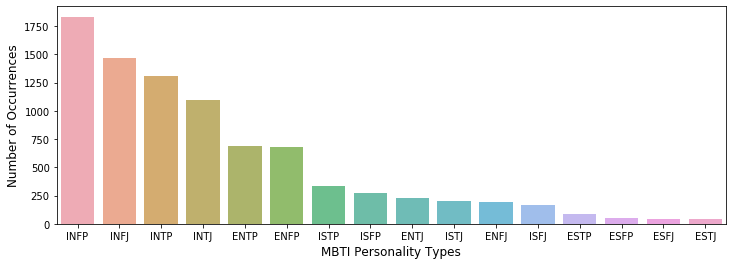

In [78]:
# Print distribution of MBTI personality types
cnt_types = df['type'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_types.index, cnt_types.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('MBTI Personality Types', fontsize=12)
plt.show()

In [79]:
# Re-classify dataset as 4 binary classifiers
df['is_E'] = df['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
df['is_S'] = df['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
df['is_T'] = df['type'].apply(lambda x: 1 if x[2] == 'T' else 0)
df['is_J'] = df['type'].apply(lambda x: 1 if x[3] == 'J' else 0)

print(df.head)

<bound method NDFrame.head of       type                                              posts  is_E  is_S  \
0     INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...     0     0   
1     ENTP  'I'm finding the lack of me in these posts ver...     1     0   
2     INTP  'Good one  _____   https://www.youtube.com/wat...     0     0   
3     INTJ  'Dear INTP,   I enjoyed our conversation the o...     0     0   
4     ENTJ  'You're fired.|||That's another silly misconce...     1     0   
5     INTJ  '18/37 @.@|||Science  is not perfect. No scien...     0     0   
6     INFJ  'No, I can't draw on my own nails (haha). Thos...     0     0   
7     INTJ  'I tend to build up a collection of things on ...     0     0   
8     INFJ  I'm not sure, that's a good question. The dist...     0     0   
9     INTP  'https://www.youtube.com/watch?v=w8-egj0y8Qs||...     0     0   
10    INFJ  'One time my parents were fighting over my dad...     0     0   
11    ENFJ  'https://www.youtube.com/watch?v=P

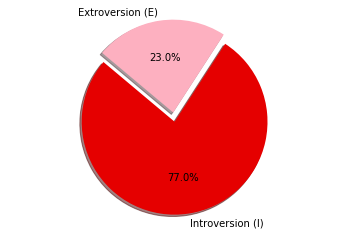

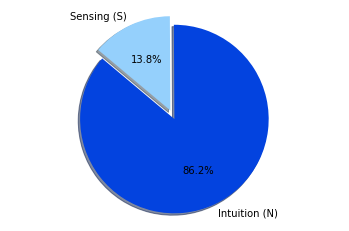

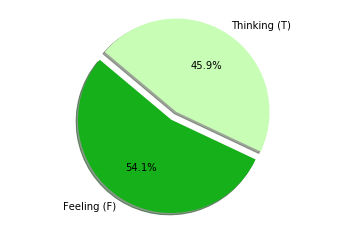

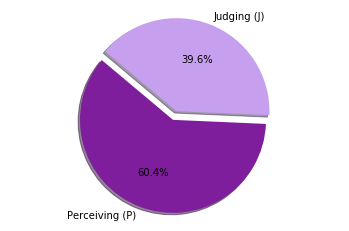

In [80]:
# Visualize I, E classifiers
labels = 'Introversion (I)', 'Extroversion (E)'
sizes = [8675 - np.count_nonzero(df['is_E']), np.count_nonzero(df['is_E'])]
colors = sns.xkcd_palette(['red', 'soft pink'])
explode = (0.1, 0)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

# Visualize N, S classifiers
labels = 'Intuition (N)', 'Sensing (S)'
sizes = [8675 - np.count_nonzero(df['is_S']), np.count_nonzero(df['is_S'])]
colors = sns.xkcd_palette(['blue', 'light blue'])
explode = (0.1, 0)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

# Visualize F, T classifiers
labels = 'Feeling (F)', 'Thinking (T)'
sizes = [8675 - np.count_nonzero(df['is_T']), np.count_nonzero(df['is_T'])]
colors = sns.xkcd_palette(['green', 'pale green'])
explode = (0.1, 0)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

# Visualize P, J classifiers
labels = 'Perceiving (P)', 'Judging (J)'
sizes = [8675 - np.count_nonzero(df['is_J']), np.count_nonzero(df['is_J'])]
colors = sns.xkcd_palette(['purple', 'lavender'])
explode = (0.1, 0)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

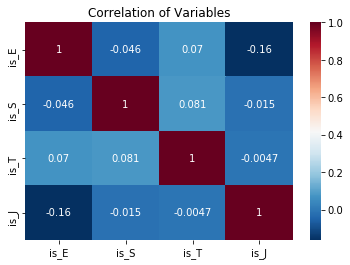

In [81]:
# Visualize correlation
sns.heatmap(df[['is_E', 'is_S', 'is_T', 'is_J']].corr(), annot = True, cmap = 'RdBu_r')
plt.title('Correlation of Variables')
plt.show()

# Preprocessing

In [82]:
# Function to clean text data
def cleaner(text):
    stemmer = PorterStemmer()                                       
    text = text.replace('|||', ' ')
    text = re.sub(r'\bhttps?:\/\/.*?[\r\n]*? ', 'URL ', text, flags=re.MULTILINE)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.translate(str.maketrans('', '', string.digits))      
    text = text.lower().strip()                                      
    final_text = []
    for w in text.split():
        if w not in stop:
            final_text.append(stemmer.stem(w.strip()))
    return ' '.join(final_text)

In [83]:
df_working = df.copy()

# Convert to binary classifiers
df_working['I-E'] = df_working['type'].map(lambda x: 'Introversion' if x[0] == 'I' else 'Extroversion')
df_working['N-S'] = df_working['type'].map(lambda x: 'Intuition' if x[1] == 'N' else 'Sensing')
df_working['T-F'] = df_working['type'].map(lambda x: 'Thinking' if x[2] == 'T' else 'Feeling')
df_working['J-P'] = df_working['type'].map(lambda x: 'Judging' if x[3] == 'J' else 'Perceiving')

df_working.head()

,type,posts,is_E,is_S,is_T,is_J,I-E,N-S,T-F,J-P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,1,Introversion,Intuition,Feeling,Judging
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,0,Extroversion,Intuition,Thinking,Perceiving
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,0,Introversion,Intuition,Thinking,Perceiving
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,1,Introversion,Intuition,Thinking,Judging
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,1,Extroversion,Intuition,Thinking,Judging


In [84]:
# Run CountVectorizer on posts column
posts = df_working['posts'].copy()
posts = posts.apply(lambda x: x.replace('|||', ' ')) # Replaces post separators with empty space
posts.head()

cv = CountVectorizer()
cv.fit_transform(posts)

<8675x145412 sparse matrix of type '<class 'numpy.int64'>'
	with 4516646 stored elements in Compressed Sparse Row format>

In [85]:
# # Convert posts to dataframe to see distribution of words
# df_posts = pd.DataFrame(cv.transform(posts).todense(), columns=cv.get_feature_names())

# df_posts.head()
# df_posts.shape

# print(df_posts.sum().sort_values(ascending=False).head(10)) # Print top 10 words in posts

In [86]:
# Create stopwords list including 16 MBTI types to avoid biasing the model
types = ['infj', 'entp', 'intp', 'intj', 'entj', 'enfj', 'infp', 'enfp', 'isfp', 'istp', 'isfj', 'istj', 'estp', 'esfp', 'estj', 'esfj']

stop = stopwords.words('english')

for type in types:
    stop.append(type)

stop_rev = stop    
print(stop_rev)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [87]:
# # Re-run CountVectorizer to exclude stopwords, allow 2-word pairs, and limit the number of columns to 1000
# cv = CountVectorizer(stop_words=stop_rev, ngram_range=(1,2), max_features=1000)
# cv.fit(posts)
# cv.transform(posts)

# cv.transform(posts).todense()
# df_posts = pd.DataFrame(cv.transform(posts).todense(), columns=cv.get_feature_names())

# df_posts.head()
# df_posts.shape

# print(df_posts.sum().sort_values(ascending=False).head(10)) # Print top 10 words in posts

In [88]:
# Run a final CountVectorizer on posts to include cleaning preprocessor arguments
cv = CountVectorizer(preprocessor=cleaner, stop_words=stop_rev, ngram_range=(1,2), max_features=1000)
cv.fit_transform(posts)

cv.transform(posts).todense()
df_posts = pd.DataFrame(cv.transform(posts).todense(), columns=cv.get_feature_names())

df_posts.head()

print(df_posts.sum().sort_values(ascending=False).head(10)) # Print top 10 words in posts

im        79995
like      75765
think     58275
dont      52778
peopl     47904
one       39656
know      39430
get       38870
feel      37014
realli    35223
dtype: int64


# Classification

In [89]:
# Train-test split, using type variable as target and posts variable as predictor
xTrain, xTest, yTrain, yTest = train_test_split(df_posts, df['type'].values, test_size = 0.30, random_state = 42)

print('X Train:', xTrain.shape, '   ', 'X Test:', xTest.shape, '   ', 'Y Train:', yTrain.shape, '   ', 'Y Test:', yTest.shape)

X Train: (6072, 1000)     X Test: (2603, 1000)     Y Train: (6072,)     Y Test: (2603,)


Text(0, 0.5, 'Explained Variance Ratio')

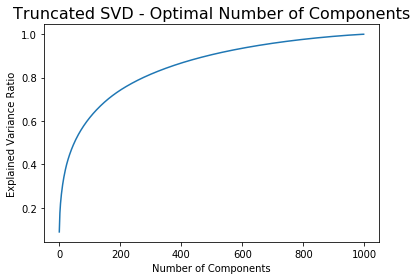

In [91]:
# Run Truncated SVD

# First use max components and graph the explained variance ratio to find cutoff point
tsvd = TruncatedSVD(n_components = 999)
tsvd.fit(xTrain)

plt.plot(range(999), tsvd.explained_variance_ratio_.cumsum())
plt.title('Truncated SVD - Optimal Number of Components', fontsize = 16)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')

In [90]:
# # Run CountVectorizer on the X train / test ('posts' column) using the arguments identified earlier
# cv = CountVectorizer(preprocessor = cleaner, stop_words = stop_rev, ngram_range = (1, 2), max_features = 1000)
# cv.fit(xTrain)
# xTrain_cv = cv.transform(xTrain)

In [93]:
# Run a Truncated SVD with 175 components
tsvd = TruncatedSVD(n_components = 175)
tsvd.fit(xTrain)

xTrain_tsvd = tsvd.transform(xTrain)

xTest_tsvd = tsvd.transform(xTest)

## Random Forest Classifier

In [ ]:
# Parameters: 30 estimators, min 50 samples per leaf node, out-of-bag samples to estimate generalization accuracy
rfc = RandomForestClassifier(n_estimators = 30, min_samples_leaf = 50, oob_score = True, n_jobs = -1, random_state = 123)
rfc.fit(xTrain_tsvd, yTrain)

print('TRAINING SET')
print('Accuracy:', rfc.score(xTrain_tsvd, yTrain))
print('Confusion Matrix:')
print(confusion_matrix(yTrain, rfc.predict(xTrain_tsvd)))
print('Classification Report')
print(classification_report(yTrain, rfc.predict(xTrain_tsvd)))

print()
print('TEST SET')
print('Accuracy:', rfc.score(xTest_tsvd, yTest))
print('Confusion Matrix:')
print(confusion_matrix(yTest, rfc.predict(xTest_tsvd)))
print('Classification Report')
print(classification_report(yTest, rfc.predict(xTest_tsvd)))

## KNeighbors Classifier

In [ ]:
# Search for the optimal number of neighbors to use
error_rate = []

for i in range(4, 14):
    knn_lc = KNeighborsClassifier(n_neighbors = i)
    knn_lc.fit(xTrain_tsvd, yTrain)

    pred_i = knn_lc.predict(xTest_tsvd)
    error_rate.append(np.mean(pred_i != yTest))

plt.plot(range(4, 14), error_rate, color = 'red', linestyle = 'dashed', marker = 'o', markerfacecolor = 'black', markersize = 10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [ ]:
k_dict = {'n_neighbors' : [7, 9, 11, 13, 15],
          'weights' : ['uniform', 'distance'],
          'p' : [1, 2]}                         # p = power parameter for the Minkowski metric, 1 = Manhattan, 2 = Euclidean

knn = KNeighborsClassifier()
gs = GridSearchCV(knn, k_dict, verbose = 2, n_jobs = -1)
gs.fit(xTrain_tsvd, yTrain)

In [ ]:
print('Best score:', gs.best_score_)
print('Best parameters:', gs.best_params_)

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 13, weights = 'distance')
knn.fit(xTrain_tsvd, yTrain)

print('TRAINING SET')
print('Accuracy:', knn.score(xTrain_tsvd, yTrain))
print('Confusion Matrix:')
print(confusion_matrix(yTrain, knn.predict(xTrain_tsvd)))
print('Classification Report:')
print(classification_report(yTrain, knn.predict(xTrain_tsvd)))

print()
print('TEST SET')
print('Accuracy:', knn.score(xTest_tsvd, yTest))
print('Confusion Matrix:')
print(confusion_matrix(yTest, knn.predict(xTest_tsvd)))
print('Classification Report:')
print(classification_report(yTest, knn.predict(xTest_tsvd)))

# Multinomial Naive Bayes

In [ ]:
df_nb = df.copy()

# Convert to binary classifiers
df_nb['I-E'] = df_nb['type'].map(lambda x: 0 if x[0] == 'I' else 1)
df_nb['N-S'] = df_nb['type'].map(lambda x: 0 if x[0] == 'N' else 1)
df_nb['T-F'] = df_nb['type'].map(lambda x: 0 if x[0] == 'T' else 1)
df_nb['J-P'] = df_nb['type'].map(lambda x: 0 if x[0] == 'J' else 1)

df_nb = df_nb.drop(columns = ["type"])

df_nb.head()

In [ ]:
posts = df_nb['posts'].copy()
posts = posts.apply(lambda x: x.replace('|||', ' ')) 
posts.head() 

cv = CountVectorizer(preprocessor=cleaner, stop_words=stop_rev, ngram_range=(1,2), max_features=1000)
cv.fit_transform(posts)

cv.transform(posts).todense()
df_nb_posts = pd.DataFrame(cv.transform(posts).todense(), columns=cv.get_feature_names())

df_nb_posts.head()

print(df_nb_posts.sum().sort_values(ascending=False).head(10)) 

## Naive Bayes Classifier for Extroversion vs. Introversion 

In [ ]:
xTrain_ie, xTest_ie, yTrain_ie, yTest_ie = train_test_split(df_nb_posts, df_nb['I-E'].values, test_size = 0.30, random_state = 42)

mnb_ie = MultinomialNB()
mnb_ie.fit(xTrain_ie, yTrain_ie)

predictions_ie = mnb_ie.predict(xTest_ie)

print(mnb_ie.score(xTest_ie, yTest_ie))

print(accuracy_score(yTest_ie, predictions_ie) * 100)

## Naive Bayes Classifier for Intuition vs. Sensing

In [ ]:
xTrain_ns, xTest_ns, yTrain_ns, yTest_ns = train_test_split(df_nb_posts, df_nb['N-S'].values, test_size = 0.30, random_state = 42)

mnb_ns = MultinomialNB()
mnb_ns.fit(xTrain_ns, yTrain_ns)

predictions_ns = mnb_ns.predict(xTest_ns)

print(mnb_ns.score(xTest_ns, yTest_ns))

print(accuracy_score(yTest_ns, predictions_ns) * 100)

## Naive Bayes Classifier for Thinking vs. Feeling

In [ ]:
xTrain_tf, xTest_tf, yTrain_tf, yTest_tf = train_test_split(df_nb_posts, df_nb['T-F'].values, test_size = 0.30, random_state = 42)

mnb_jtf= MultinomialNB()
mnb_tf.fit(xTrain_tf, yTrain_tf)

predictions_tf = mnb_tf.predict(xTest_tf)

print(mnb_tf.score(xTest_tf, yTest_tf))

print(accuracy_score(yTest_tf, predictions_tf) * 100)

## Naive Bayes Classifier for Judging vs. Perceiving

In [ ]:
xTrain_jp, xTest_jp, yTrain_jp, yTest_jp = train_test_split(df_nb_posts, df_nb['J-P'].values, test_size = 0.30, random_state = 42)

mnb_jp = MultinomialNB()
mnb_jp.fit(xTrain_jp, yTrain_jp)

predictions_jp = mnb_jp.predict(xTest_jp)

print(mnb_jp.score(xTest_jp, yTest_jp))

print(accuracy_score(yTest_jp, predictions_jp) * 100)

# Recurrent Neural Network (RNN)

In [ ]:
# df_rnn = df.copy()

# df_rnn['cleanPosts'] = df_rnn.apply(lambda row: cleaner(row['posts'], stop_rev), axis = 1)

# df_rnn.head()

In [ ]:
# df_rnn.to_csv("mbti_types_2.csv")
# data_lm = TextLMDataBunch.from_csv("", "mbti_types_2.csv", valid_pct = 0.2, text_cols = 'cleanPosts', label_cols = 'type')
# data_lm.show_batch()

In [ ]:
# # First use DataBunch data_lm to create a new LSTM network
# learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

# # Find its optimal learning rate
# learn.lr_find()

In [ ]:
# learn.recorder.plot()

In [ ]:
# learn.fit_one_cycle(1, 1e-3)
# learn.unfreeze()

# # Train for 5 epochs with a learning rate of 1e-3 and momentum of slice(0.8, 0.7)
# learn.fit_one_cycle(5, 1e-3, moms=(0.8, 0.7))

# learn.save('lm-trained')
# learn.save_encoder('ft_enc')

In [ ]:
# # Use language model to create classifier
# data_cl = TextClasDataBunch.from_csv('', 'mbti_types_2.csv', valid_pct=0.2, vocab=data_lm.train_ds.vocab, bs=10, text_cols='cleanPosts', label_cols='type')
# data_cl.show_batch()

In [ ]:
# classifier = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5)
# classifier.load_encoder('ft_enc')
# classifier.lr_find()
# classifier.recorder.plot()

In [ ]:
# classifier.fit_one_cycle(1, 5e-2, moms=(0.8, 0.7))
# classifier.save('first')
# classifier.load('first')

In [ ]:
# classifier.freeze_to(-2)
# classifier.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

## Recurrent Neural Network Using LSTM

In [ ]:
df_rnn = df.copy()

df_rnn['cleanPosts'] = df_rnn.apply(lambda row: cleaner(row['posts'], stop_rev), axis = 1)

df_rnn.head()

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = kpp.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_rnn['cleanPosts'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

In [ ]:
X = tokenizer.texts_to_sequences(df_rnn['cleanPosts'].values)
X = kpp.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

In [ ]:
Y = pd.get_dummies(df['type']).values
print('Shape of label tensor:', Y.shape)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

In [ ]:
model = tf.keras.Sequential()
model.add(kl.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(kl.SpatialDropout1D(0.2))
model.add(kl.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(kl.Dense(16, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:

new_post = ['Hey,  I’m not looking for social contacts. I have friends. I’m fine']
seq = tokenizer.texts_to_sequences(new_post)
padded = kpp.sequence.pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['infj', 'entp', 'intp', 'intj', 'entj', 'enfj', 'infp', 'enfp', 'isfp', 'istp', 'isfj', 'istj', 'estp', 'esfp', 'estj', 'esfj']
print(pred, labels[np.argmax(pred)])